# 💳 Système intelligent de scoring de crédit pour microfinance / banque

🎯 **Objectif métier** : prédire si un client présente un risque de défaut dans les 2 prochaines années, afin d’aider les institutions financières à mieux gérer leurs décisions de crédit.

🏦 **Cibles du projet** :
- Microfinances, banques locales, néobanques africaines
- Équipes risque, scoring, ou digital banking

📦 **Données utilisées** : [GiveMeSomeCredit - Kaggle](https://www.kaggle.com/c/GiveMeSomeCredit/data)

📌 **Variable cible** : `SeriousDlqin2yrs` (1 = client a fait défaut, 0 = bon payeur)

🔧 **Outils principaux** : Python, XGBoost, SHAP, Streamlit


### Importation des bibliothèques principales : manipulation, visualisation, machine learning


In [16]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# Explicabilité
import shap

# Divers
import warnings
warnings.filterwarnings("ignore")

# Affichage matplotlib dans le notebook
%matplotlib inline


📦 Importation des bibliothèques nécessaires :

- `pandas`, `numpy` : manipulation des données
- `matplotlib`, `seaborn` : visualisation
- `sklearn` : machine learning (split, évaluation)
- `xgboost` : algorithme puissant de boosting

Ces outils sont couramment utilisés dans les projets d’analyse prédictive.


## 📂 Chargement du dataset

On utilise le fichier `cs-training.csv`.  
Ce fichier contient des informations financières et comportementales sur plusieurs milliers de clients.


In [17]:
# Charger le dataset
df = pd.read_csv("cs-training.csv", index_col=0)

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Aperçu des premières lignes
df.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 📋 Description des variables

| Variable | Description |
|----------|-------------|
| `SeriousDlqin2yrs` | **Cible** : 1 = défaut dans les 2 ans, 0 = non |
| `RevolvingUtilizationOfUnsecuredLines` | % de crédit utilisé vs crédit dispo |
| `age` | Âge du client |
| `NumberOfTime30-59DaysPastDueNotWorse` | Retards de 30-59 jours |
| `DebtRatio` | Ratio d’endettement |
| `MonthlyIncome` | Revenu mensuel |
| `NumberOfOpenCreditLinesAndLoans` | Nombre de crédits ouverts |
| `NumberOfTimes90DaysLate` | Retards ≥ 90 jours |
| `NumberRealEstateLoansOrLines` | Prêts immobiliers |
| `NumberOfTime60-89DaysPastDueNotWorse` | Retards 60-89 jours |
| `NumberOfDependents` | Nombre de personnes à charge |


In [18]:
# Dimensions
print("Nombre de lignes et colonnes :", df.shape)

# Types de données et colonnes
df.info()


Nombre de lignes et colonnes : (150000, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents           

🧹 Prétraitement :

- Suppression éventuelle d’une colonne inutile (`Unnamed: 0`)
- Aperçu des premières lignes du dataset pour vérifier la structure

🎯 Objectif : obtenir un DataFrame propre avant l’analyse.


In [4]:
# Colonnes avec valeurs manquantes
df.isnull().sum()[df.isnull().sum() > 0]


MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

In [5]:
# Remplir les NaN avec la médiane pour les colonnes numériques
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)

# Vérification
df.isnull().sum().sum()


np.int64(0)

✅ Traitement des valeurs manquantes :

- Remplissage par la **médiane** (plutôt que la moyenne) pour limiter l’influence des valeurs extrêmes.

Le dataset est maintenant prêt pour l’analyse de la cible.


## 🎯 Analyse de la variable cible (`SeriousDlqin2yrs`)

Notre objectif est de prédire si un client fera défaut de paiement (`1`) ou non (`0`).  
Analysons l’équilibre de cette variable pour comprendre s’il y a un déséquilibre important.


In [6]:
# Distribution
df['SeriousDlqin2yrs'].value_counts(normalize=True) * 100


SeriousDlqin2yrs
0    93.316
1     6.684
Name: proportion, dtype: float64

📊 **Distribution de la cible :**

On remarque un déséquilibre important :
- Environ **93%** des clients **ne font pas défaut**
- Seulement **7%** font défaut

➡️ Ce déséquilibre doit être pris en compte dans l’évaluation et l’entraînement du modèle, car il peut biaiser la prédiction vers la majorité.


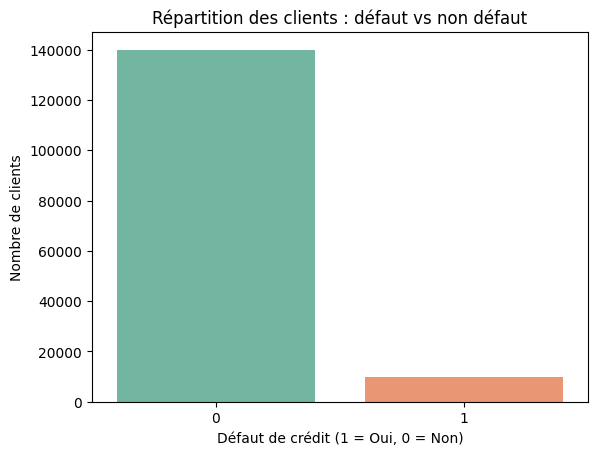

In [7]:
# Visualisation
sns.countplot(x='SeriousDlqin2yrs', data=df, palette='Set2')
plt.title("Répartition des clients : défaut vs non défaut")
plt.xlabel("Défaut de crédit (1 = Oui, 0 = Non)")
plt.ylabel("Nombre de clients")
plt.show()


📉 Le graphique confirme visuellement ce déséquilibre.  
Le modèle pourrait avoir tendance à prédire "0" par défaut s’il n’est pas correctement ajusté (`scale_pos_weight` dans XGBoost).


## 🔀 Séparation des données d'entraînement et de test

Nous séparons les données en deux ensembles :
- `train` (80%) : pour entraîner le modèle
- `test` (20%) : pour évaluer la performance réelle

On utilise ici `stratify=y` pour respecter la proportion de défauts.


In [8]:
# Séparer les variables explicatives (X) et la cible (y)
X = df.drop("SeriousDlqin2yrs", axis=1)
y = df["SeriousDlqin2yrs"]

# Split avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train :", X_train.shape)
print("Test  :", X_test.shape)


Train : (120000, 10)
Test  : (30000, 10)


## ⚙️ Entraînement du modèle XGBoost

Nous utilisons `XGBoost`, un algorithme de boosting très performant pour les problèmes de scoring de crédit.

Avantages :
- Gère bien les déséquilibres de classes
- Très utilisé dans la finance
- Rapide et efficace


In [9]:
# Création du modèle
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=8  # ajusté selon le déséquilibre (à ajuster selon ton dataset)
)

# Entraînement
xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


## 📊 Évaluation du modèle

Nous allons mesurer :
- La **matrice de confusion**
- Le **rapport de classification** (recall, précision, F1-score)
- Le **score ROC AUC** (capacité du modèle à classer correctement)

Ces métriques sont plus pertinentes que l'accuracy pour un dataset déséquilibré.


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Prédictions
y_pred = xgb_model.predict(X_test)

# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Score ROC AUC
y_proba = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("Score ROC AUC :", round(roc_auc, 4))


Matrice de confusion :
[[25120  2875]
 [  791  1214]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     27995
           1       0.30      0.61      0.40      2005

    accuracy                           0.88     30000
   macro avg       0.63      0.75      0.67     30000
weighted avg       0.92      0.88      0.90     30000

Score ROC AUC : 0.8509


📋 **Analyse des performances du modèle :**

- **Recall (rappel)** pour la classe 1 (défaut) : indique combien de clients défaillants ont été correctement identifiés.
- **Precision (précision)** pour la classe 1 : indique parmi les clients prédits comme défaillants, combien le sont réellement.
- **F1-score** : compromis entre précision et rappel.
- **ROC AUC score** : mesure globale de performance, insensible au seuil de classification. Plus proche de 1 = meilleur.

➡️ Dans un contexte de crédit, on préfère souvent **maximiser le rappel**, pour éviter de rater des clients risqués.


## 🔍 Interprétation du modèle avec SHAP

L'explicabilité est cruciale dans le secteur bancaire.  
Nous utilisons SHAP (SHapley Additive exPlanations) pour visualiser :
- Les variables qui influencent le plus le modèle
- L’impact de chaque variable sur chaque prédiction


 99%|===================| 29843/30000 [01:57<00:00]        

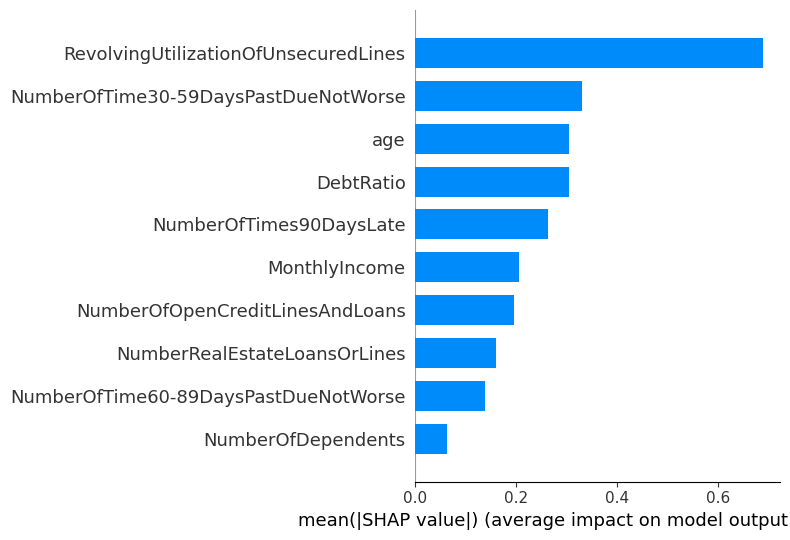

In [11]:
# Initialiser l'explainer
explainer = shap.Explainer(xgb_model, X_train)

# Calcul des valeurs SHAP
shap_values = explainer(X_test)

# Résumé global
shap.summary_plot(shap_values, X_test, plot_type="bar")


📊 **Variables les plus influentes selon SHAP :**

Le graphique montre les variables ayant le plus d’impact **en moyenne** sur les prédictions du modèle.  
Par exemple :
- `RevolvingUtilizationOfUnsecuredLines` ou `DebtRatio` sont très déterminants.

➡️ Ces insights sont utiles pour les analystes crédit et peuvent guider des actions ou des règles métier.


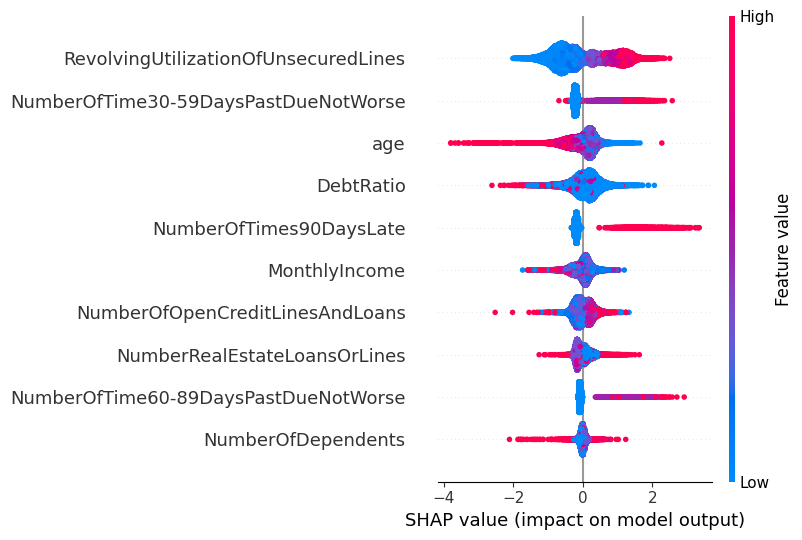

In [12]:
shap.summary_plot(shap_values, X_test)


🌀 Ce graphique montre l’effet de **chaque valeur** de variable sur la prédiction :

- Plus une valeur est à droite, plus elle **augmente** la probabilité de défaut.
- En rouge : valeurs élevées de la variable  
- En bleu : valeurs faibles

➡️ On observe par exemple que des **valeurs élevées de `DebtRatio`** sont fortement corrélées au défaut.


## 👤 Prédiction personnalisée pour un nouveau client

Nous simulons ici un **nouveau dossier client** pour voir si le modèle estime un risque de défaut (`1`) ou non (`0`).  
Nous utiliserons également **SHAP** pour expliquer la décision du modèle.


In [13]:
# Exemple de client fictif (tu peux modifier les valeurs)
client = pd.DataFrame([{
    'RevolvingUtilizationOfUnsecuredLines': 0.35,
    'age': 35,
    'NumberOfTime30-59DaysPastDueNotWorse': 0,
    'DebtRatio': 0.5,
    'MonthlyIncome': 3200,
    'NumberOfOpenCreditLinesAndLoans': 5,
    'NumberOfTimes90DaysLate': 0,
    'NumberRealEstateLoansOrLines': 1,
    'NumberOfTime60-89DaysPastDueNotWorse': 0,
    'NumberOfDependents': 2
}])

# Prédiction
proba = xgb_model.predict_proba(client)[0][1]
classe = xgb_model.predict(client)[0]

# Affichage du résultat
print(f"🔎 Probabilité de défaut : {proba:.2%}")
print(f"✅ Décision : {'Risque de défaut (1)' if classe == 1 else 'Client fiable (0)'}")


🔎 Probabilité de défaut : 16.97%
✅ Décision : Client fiable (0)


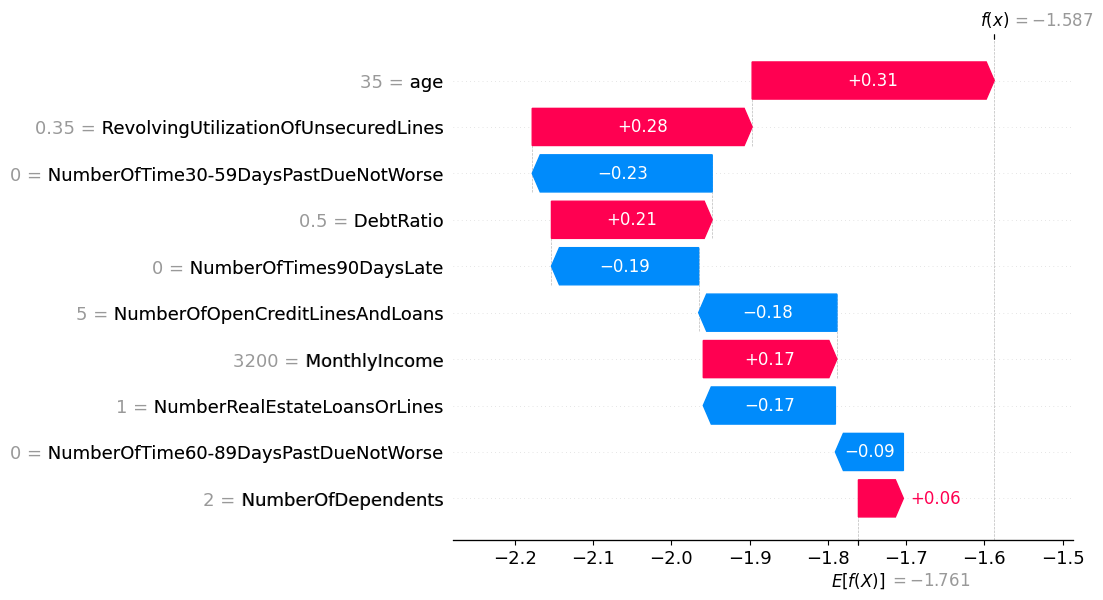

In [14]:
# Calcul des valeurs SHAP pour le client
shap_client = explainer(client)

# Graphique d’explication locale
shap.plots.waterfall(shap_client[0])


📌 **Interprétation locale** :

Ce graphique montre pour **un client spécifique** :
- Quelles variables ont **tiré la prédiction vers le défaut (1)** (rouge)
- Et lesquelles l’ont **protégée du défaut (0)** (bleu)

➡️ Exemple : un `MonthlyIncome` élevé ou peu d’incidents de paiement peuvent réduire le risque estimé.


### 🧠 Interprétation professionnelle

- Le modèle estime que ce client a **16,97%** de chances de faire défaut.
- Grâce à SHAP, on sait que un haut `DebtRatio` est un facteur aggravant.
- Cette interprétation est **obligatoire** en finance régulée pour justifier les décisions.

💼 Ce module de prédiction peut être intégré dans un tableau de bord pour les analystes crédit.


In [15]:
import joblib

# Créer dossier s'il n'existe pas
import os
os.makedirs('../models', exist_ok=True)

# Sauvegarder le modèle entraîné
joblib.dump(xgb_model, '../models/xgb_model.pkl')


['../models/xgb_model.pkl']

In [22]:
import shap
print(shap.__version__)

0.48.0


## ✅ Conclusion du projet

🔍 Ce projet démontre la création d’un **système intelligent de scoring de crédit** basé sur des données clients, combinant :
- modélisation prédictive,
- explicabilité (via SHAP),
- interface utilisateur web intuitive,
- et génération automatique de rapports.

---

### 📌 Étapes clés du projet

- **Préparation des données** : nettoyage, traitement des valeurs manquantes, exploration de la variable cible  
- **Modélisation avec XGBoost** : gestion du déséquilibre des classes pour améliorer la détection des clients à risque  
- **Évaluation** : des métriques adaptées (ROC AUC, F1-score) ont montré de bonnes performances  
- **Interprétation des prédictions** : SHAP permet de justifier chaque décision, globalement et individuellement  
- **Simulation de nouveaux clients** : les prédictions sont visualisables et accompagnées d'une explication automatique

---

### 🌍 Déploiement & génération multilingue

- L'application est **déployée avec Streamlit**, avec une interface **bilingue FR/EN** selon la langue du navigateur  
- Un rapport explicatif est généré **automatiquement** via l’API **Cohere**, en **français ou en anglais**  
- Les résultats peuvent être exportés au format **PDF** ou **Excel professionnel**

---

### 🔮 Perspectives d’amélioration

- Intégration dans une API ou un CRM  
- Suivi des performances en production (monitoring, drift, feedback utilisateur)  
- Amélioration UI/UX et sécurité (authentification, rôles)  
- Optimisation des hyperparamètres via recherche automatique

---

💼 Ce projet constitue une base **solide, transparente et professionnelle** pour des solutions d’analyse de crédit automatisées dans un contexte réel, tout en restant conforme aux exigences réglementaires.
